In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os

sys.path.insert(0, os.path.abspath("../.."))
sys.path.append(os.path.abspath("../../backend"))
sys.path.append(os.path.abspath(""))


from rdflib.plugins.stores.sparqlstore import SPARQLStore

from backend.ontology import OntologyConfig, OntologyManager, Graph
from backend.explorative.explorative_support import (
    GuidanceManager,
)
from backend.explorative.llm_query import (
    LLMQuery,
    EnrichedEntitiesRelations
)
from backend.eval_config import YAGO_CONFIGS
import networkx as nx
config = YAGO_CONFIGS[-1]
store = SPARQLStore(
    config.sparql_endpoint,
    method="POST_FORM",
    params={"infer": False, "sameAs": False},
)
graph = Graph(store=store)

oconfig = OntologyConfig()


In [3]:
ontology_manager = OntologyManager(oconfig, graph)
topic_man = GuidanceManager(
    conn_str=config.conn_str,
    oman=ontology_manager,
    llm_model_id=config.model_id,
)
llama_model = topic_man.llama_model
querier = LLMQuery(topic=topic_man)

Loading LLM model NousResearch/Hermes-3-Llama-3.2-3B-GGUF None


ggml_cuda_init: GGML_CUDA_FORCE_MMQ:    no
ggml_cuda_init: GGML_CUDA_FORCE_CUBLAS: no
ggml_cuda_init: found 1 CUDA devices:
  Device 0: NVIDIA GeForce RTX 4090, compute capability 8.9, VMM: yes
llama_model_load_from_file_impl: using device CUDA0 (NVIDIA GeForce RTX 4090) - 23528 MiB free
llama_model_loader: loaded meta data with 38 key-value pairs and 255 tensors from /home/bkantz/.cache/huggingface/hub/models--NousResearch--Hermes-3-Llama-3.2-3B-GGUF/snapshots/3cd927095d8cbab12c743f932aa63b6f7bbfa141/./Hermes-3-Llama-3.2-3B.Q8_0.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.type str              = model
llama_model_loader: - kv   2:                               general.name str              = Hermes 3 Llama 3.2 3b Base Fft Chatml...
llama

In [16]:
final_progress = querier.run_query("A scholarly article is depicted by an image object", enable_cache=False)

Llama.generate: 219 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =      70.25 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =     900.84 ms /   171 runs   (    5.27 ms per token,   189.82 tokens per second)
llama_perf_context_print:       total time =    2136.79 ms /   172 tokens
Llama.generate: 219 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =      70.25 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =     889.94 ms /   171 runs   (    5.20 ms per token,   192.15 tokens per second)
llama_perf_context_print:       total time =    2122.13 ms /   172 tokens


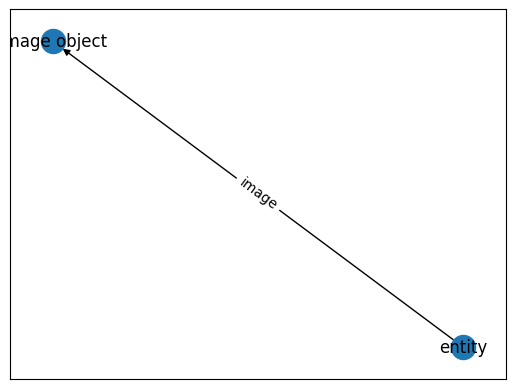

In [17]:
def viz_graph(erl: EnrichedEntitiesRelations):
    G = nx.DiGraph()
    for node in erl.entities:
        G.add_node(node.identifier, label=node.type)
    for link in erl.relations:
        G.add_edge(
            link.entity,
            link.target,
            # weight=link.link.instance_count,
            label=link.relation,
        )
    pos = nx.spring_layout(G)
    nx.draw_networkx(
        G,
        pos,
        with_labels=True,
        labels={node.identifier: node.type for node in erl.entities},
    )
    nx.draw_networkx_edge_labels(
        G,
        pos,
        edge_labels={
            (link.entity, link.target): link.relation for link in erl.relations
        },
    )
    return G


viz_graph(final_progress.enriched_relations)

In [18]:
[
    ent.identifier for ent in final_progress.enriched_relations.entities
]

['image object', 'scholarly article']

In [19]:
final_progress.enriched_relations.relations[0].entity, final_progress.enriched_relations.relations[0].target

('image object', 'scholarly article')

In [ ]:
len(final_progress.relations_steps[-2].entities)

2

: 

In [9]:
len(final_progress.enriched_relations.entities)

3